# Sudoku solving with guided reverse SDE (score model)

This notebook solves Sudoku puzzles using a **pretrained score model** and a **guided Euler–Maruyama sampler**.

Key modeling choices:

- **Probability path (training / conditioning).**  
  We use a *linear Gaussian path*
  $$
  x_t = \alpha(t)\,z + \beta(t)\,\varepsilon,
  \qquad
  \alpha(t)=t,\ \beta(t)=1-t,
  \qquad
  \varepsilon \sim \mathcal N(0,I).
  $$

- **Sampling dynamics.**  
  We use $\beta(t)$ directly as the diffusion coefficient (noise scale).  
  This is **not** a canonical diffusion-model choice; empirically, we find that this parametrization
  behaves more robustly for Sudoku than standard $\sigma$ schedule.

---

## Two-stage constraint enforcement (path → hard)

We enforce Sudoku givens using a **two-stage masking strategy**, controlled by a time threshold
$\texttt{threshold\_hard}$.

Let $m \in \{0,1\}^d$ denote the binary mask of given cells
($m_i = 1$ for givens, $m_i = 0$ for free variables),
and let $z$ denote the fixed puzzle values.

---

### Stage A: diffusion-consistent constraint injection, $t \le \texttt{threshold\_hard}$

In the early (high-noise) phase of sampling, we inject the givens at the **correct noise level**
corresponding to the forward Gaussian path. Specifically, we sample
$$
x_t^{\text{given}} = \alpha(t)\,z + \beta(t)\,\varepsilon,
\qquad \varepsilon \sim \mathcal N(0,I),
$$
and overwrite the constrained dimensions:
$$
x_t \;\leftarrow\; m \odot x_t^{\text{given}} \;+\; (1-m)\odot x_t.
$$

This ensures that the given cells remain **consistent with the marginal distribution at time $t$**,
rather than being forced prematurely to their clean (noise-free) values.

---

### Stage B: hard constraint enforcement, $t > \texttt{threshold\_hard}$

In low-noise phase, we enforce the Sudoku constraints exactly by clamping the givens:
$$
x_t \;\leftarrow\; m \odot z \;+\; (1-m)\odot x_t.
$$

This guarantees that the final sampled solution satisfies all provided digits.

# Setup and useful functions

In [1]:
from abc import ABC, abstractmethod
from typing import Optional, List, Type, Tuple, Dict
import math

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.axes._axes import Axes
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
from torch.func import vmap, jacrev
from tqdm import tqdm
import seaborn as sns
from sklearn.datasets import make_moons, make_circles
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import imageio.v2 as imageio
from PIL import Image, ImageDraw, ImageFont


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device == "cpu":
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [2]:
class Sampleable(ABC):
    """
    Distribution which can be sampled from
    """ 
    @abstractmethod
    def sample(self, num_samples: int) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        """
        Args:
            - num_samples: the desired number of samples
        Returns:
            - samples: shape (batch_size, ...)
            - labels: shape (batch_size, label_dim)
        """
        pass

class IsotropicGaussian(nn.Module, Sampleable):
    """
    Sampleable wrapper around torch.randn
    """
    def __init__(self, shape: List[int], std: float = 1.0):
        """
        shape: shape of sampled data
        """
        super().__init__()
        self.shape = shape
        self.std = std
        #self.dummy = nn.Buffer(torch.zeros(1)) # Will automatically be moved when self.to(...) is called...
        self.register_buffer("dummy", torch.zeros(1))
        
    def sample(self, num_samples) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.std * torch.randn(num_samples, *self.shape).to(self.dummy.device), None

In [3]:
class ConditionalProbabilityPath(nn.Module, ABC):
    """
    Abstract base class for conditional probability paths
    """
    def __init__(self, p_simple: Sampleable, p_data: Sampleable):
        super().__init__()
        self.p_simple = p_simple
        self.p_data = p_data

    def sample_marginal_path(self, t: torch.Tensor) -> torch.Tensor:
        """
        Samples from the marginal distribution p_t(x) = p_t(x|z) p(z)
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - x: samples from p_t(x), (num_samples, c, h, w)
        """
        num_samples = t.shape[0]
        z, _ = self.sample_conditioning_variable(num_samples)
        x = self.sample_conditional_path(z, t)
        return x

    @abstractmethod
    def sample_conditioning_variable(self, num_samples: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Samples the conditioning variable z and label y
        Args:
            - num_samples: the number of samples
        Returns:
            - z: (num_samples, c, h, w)
            - y: (num_samples, label_dim)
        """
        pass
    
    @abstractmethod
    def sample_conditional_path(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Samples from the conditional distribution p_t(x|z)
        Args:
            - z: conditioning variable (num_samples, c, h, w)
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - x: samples from p_t(x|z), (num_samples, c, h, w)
        """
        pass
        
    @abstractmethod
    def conditional_vector_field(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional vector field u_t(x|z)
        Args:
            - x: position variable (num_samples, c, h, w)
            - z: conditioning variable (num_samples, c, h, w)
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - conditional_vector_field: conditional vector field (num_samples, c, h, w)
        """ 
        pass

    @abstractmethod
    def conditional_score(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional score of p_t(x|z)
        Args:
            - x: position variable (num_samples, c, h, w)
            - z: conditioning variable (num_samples, c, h, w)
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - conditional_score: conditional score (num_samples, c, h, w)
        """ 
        pass

In [4]:
class Alpha(ABC):
    def __init__(self):
        assert torch.allclose(
            self(torch.zeros(1,1,1,1)), torch.zeros(1,1,1,1)
        )
        # Check alpha_1 = 1
        assert torch.allclose(
            self(torch.ones(1,1,1,1)), torch.ones(1,1,1,1)
        )
        
    @abstractmethod
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates alpha_t. Should satisfy: self(0.0) = 0.0, self(1.0) = 1.0.
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - alpha_t (num_samples, 1, 1, 1)
        """ 
        pass

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt alpha_t.
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - d/dt alpha_t (num_samples, 1, 1, 1)
        """ 
        t = t.unsqueeze(1)
        dt = vmap(jacrev(self))(t)
        return dt.view(-1, 1, 1, 1)
    
class Beta(ABC):
    def __init__(self):
        # Check beta_0 = 1
        assert torch.allclose(
            self(torch.zeros(1,1,1,1)), torch.ones(1,1,1,1)
        )
        # Check beta_1 = 0
        assert torch.allclose(
            self(torch.ones(1,1,1,1)), torch.zeros(1,1,1,1)
        )
        
    @abstractmethod
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates alpha_t. Should satisfy: self(0.0) = 1.0, self(1.0) = 0.0.
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - beta_t (num_samples, 1, 1, 1)
        """ 
        pass 

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt beta_t.
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - d/dt beta_t (num_samples, 1, 1, 1)
        """ 
        t = t.unsqueeze(1)
        dt = vmap(jacrev(self))(t)
        return dt.view(-1, 1, 1, 1)

class LinearAlpha(Alpha):
    """
    Implements alpha_t = t
    """
    
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - alpha_t (num_samples, 1, 1, 1)
        """ 
        return t
    
    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt alpha_t.
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - d/dt alpha_t (num_samples, 1, 1, 1)
        """ 
        return torch.ones_like(t)

class LinearBeta(Beta):
    """
    Implements beta_t = 1-t
    """
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - t: time (num_samples, 1)
        Returns:
            - beta_t (num_samples, 1)
        """ 
        return 1-t
        
    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt alpha_t.
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - d/dt alpha_t (num_samples, 1, 1, 1)
        """ 
        return - torch.ones_like(t)

class CosineAlpha(Alpha):
    """
    Implements alpha_t = sin(0.5*pi*t)
    """
    
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        return torch.sin(0.5*math.pi*t)
    
    def dt(self, t: torch.Tensor) -> torch.Tensor:
        return 0.5*math.pi*torch.cos(0.5*math.pi*t)
        
class SinusBeta(Beta):
    """
    Implements beta_t = cos(0.5*pi*t)
    """
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        return torch.cos(0.5*math.pi*t)
        
    def dt(self, t: torch.Tensor) -> torch.Tensor:
        return -0.5*math.pi*torch.sin(0.5*math.pi*t)
    
class GaussianConditionalProbabilityPath(ConditionalProbabilityPath):
    def __init__(self, p_data: Sampleable, p_simple_shape: List[int], alpha: Alpha, beta: Beta):
        p_simple = IsotropicGaussian(shape = p_simple_shape, std = 1.0)
        super().__init__(p_simple, p_data)
        self.alpha = alpha
        self.beta = beta

    def sample_conditioning_variable(self, num_samples: int) -> torch.Tensor:
        """
        Samples the conditioning variable z and label y
        Args:
            - num_samples: the number of samples
        Returns:
            - z: (num_samples, c, h, w)
            - y: (num_samples, label_dim)
        """
        return self.p_data.sample(num_samples)


    def sample_conditioning_variable_by_index(self, idx: int) -> torch.Tensor:
        return self.p_data.sample_index(idx)
    
    def sample_conditional_path(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Samples from the conditional distribution p_t(x|z)
        Args:
            - z: conditioning variable (num_samples, c, h, w)
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - x: samples from p_t(x|z), (num_samples, c, h, w)
        """
        return self.alpha(t) * z + self.beta(t) * torch.randn_like(z)
        
    def conditional_vector_field(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional vector field u_t(x|z)
        Args:
            - x: position variable (num_samples, c, h, w)
            - z: conditioning variable (num_samples, c, h, w)
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - conditional_vector_field: conditional vector field (num_samples, c, h, w)
        """ 
        alpha_t = self.alpha(t) # (num_samples, 1, 1, 1)
        beta_t = self.beta(t) # (num_samples, 1, 1, 1)
        dt_alpha_t = self.alpha.dt(t) # (num_samples, 1, 1, 1)
        dt_beta_t = self.beta.dt(t) # (num_samples, 1, 1, 1)

        return (dt_alpha_t - dt_beta_t / beta_t * alpha_t) * z + dt_beta_t / beta_t * x

    def conditional_score(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional score of p_t(x|z)
        Args:
            - x: position variable (num_samples, c, h, w)
            - z: conditioning variable (num_samples, c, h, w)
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - conditional_score: conditional score (num_samples, c, h, w)
        """ 
        alpha_t = self.alpha(t)
        beta_t = self.beta(t)
        return (z * alpha_t - x) / beta_t ** 2

    def conditional_score_no_beta(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional score of p_t(x|z)
        Args:
            - x: position variable (num_samples, c, h, w)
            - z: conditioning variable (num_samples, c, h, w)
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - conditional_score: conditional score (num_samples, c, h, w)
        """ 
        alpha_t = self.alpha(t)
        beta_t = self.beta(t)
        return (z * alpha_t - x), beta_t ** 2

In [5]:
class ODE(ABC):
    @abstractmethod
    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor, **kwargs) -> torch.Tensor:
        """
        Returns the drift coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs, c, h, w)
            - t: time, shape (bs, 1)
        Returns:
            - drift_coefficient: shape (bs, c, h, w)
        """
        pass

class SDE(ABC):
    @abstractmethod
    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor, **kwargs) -> torch.Tensor:
        """
        Returns the drift coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs, c, h, w)
            - t: time, shape (bs, 1, 1, 1)
        Returns:
            - drift_coefficient: shape (bs, c, h, w)
        """
        pass

    @abstractmethod
    def diffusion_coefficient(self, xt: torch.Tensor, t: torch.Tensor, **kwargs) -> torch.Tensor:
        """
        Returns the diffusion coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs, c, h, w)
            - t: time, shape (bs, 1, 1, 1)
        Returns:
            - diffusion_coefficient: shape (bs, c, h, w)
        """
        pass

In [6]:
class Simulator(ABC):
    @abstractmethod
    def step(self, xt: torch.Tensor, t: torch.Tensor, dt: torch.Tensor, **kwargs):
        """
        Takes one simulation step
        Args:
            - xt: state at time t, shape (bs, c, h, w)
            - t: time, shape (bs, 1, 1, 1)
            - dt: time, shape (bs, 1, 1, 1)
        Returns:
            - nxt: state at time t + dt (bs, c, h, w)
        """
        pass

    @torch.no_grad()
    def simulate(self, x: torch.Tensor, ts: torch.Tensor, **kwargs):
        """
        Simulates using the discretization gives by ts
        Args:
            - x_init: initial state, shape (bs, c, h, w)
            - ts: timesteps, shape (bs, nts, 1, 1, 1)
        Returns:
            - x_final: final state at time ts[-1], shape (bs, c, h, w)
        """
        nts = ts.shape[1]
        for t_idx in tqdm(range(nts - 1)):
            t = ts[:, t_idx]
            h = ts[:, t_idx + 1] - ts[:, t_idx]
            x = self.step(x, t, h, **kwargs)
        return x

    @torch.no_grad()
    def simulate_with_trajectory(self, x: torch.Tensor, ts: torch.Tensor, use_tqdm=True, **kwargs):
        """
        Simulates using the discretization gives by ts
        Args:
            - x: initial state, shape (bs, c, h, w)
            - ts: timesteps, shape (bs, nts, 1, 1, 1)
        Returns:
            - xs: trajectory of xts over ts, shape (batch_size, nts, c, h, w)
        """
        xs = [x.clone()]
        nts = ts.shape[1]

        iterator = range(nts - 1)
        if use_tqdm:
            iterator = tqdm(iterator)

        for t_idx in iterator:
            t = ts[:,t_idx]
            h = ts[:, t_idx + 1] - ts[:, t_idx]
            x = self.step(x, t, h, **kwargs)
            xs.append(x.clone())
        return torch.stack(xs, dim=1)

class EulerSimulator(Simulator):
    def __init__(self, ode: ODE):
        self.ode = ode
        
    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor, **kwargs):
        return xt + self.ode.drift_coefficient(xt,t, **kwargs) * h

class EulerMaruyamaSimulator(Simulator):
    def __init__(self, sde: SDE):
        self.sde = sde
        
    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor, **kwargs):
        return xt + self.sde.drift_coefficient(xt,t, **kwargs) * h + self.sde.diffusion_coefficient(xt,t, **kwargs) * torch.sqrt(h) * torch.randn_like(xt)

class GuidedEulerMaruyamaSimulator(Simulator):
    def __init__(self, sde: SDE):
        self.sde = sde
        
    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor, z_guided, mask, **kwargs):
        drift_coef = self.sde.drift_coefficient(xt,t, **kwargs)
        diff_coef = self.sde.diffusion_coefficient(xt,t, **kwargs)

        x_pred = xt + drift_coef * h + diff_coef * torch.sqrt(h) * torch.randn_like(xt)
        x_pred = z_guided * mask + (1-mask)*x_pred
        
        return x_pred

class GuidedPathEulerMaruyamaSimulator(Simulator):
    def __init__(self, sde: SDE, threshold_hard=1.0):
        self.sde = sde
        self.threshold_hard = threshold_hard
        
    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor, z_guided, mask, path, **kwargs):
        if t.reshape(-1)[0] <= self.threshold_hard:
            x_guided = path.sample_conditional_path(z_guided, t)
            xt = x_guided * mask + (1-mask)*xt
        drift_coef = self.sde.drift_coefficient(xt,t, **kwargs)
        diff_coef = self.sde.diffusion_coefficient(xt,t, **kwargs)
        
        x_pred = xt + drift_coef * h + diff_coef * torch.sqrt(h) * torch.randn_like(xt)
        
        if t.reshape(-1)[0] > self.threshold_hard:
            x_pred = z_guided * mask + (1-mask)*x_pred  
        return x_pred
        
def record_every(num_timesteps: int, record_every: int) -> torch.Tensor:
    """
    Compute the indices to record in the trajectory given a record_every parameter
    """
    if record_every == 1:
        return torch.arange(num_timesteps)
    return torch.cat(
        [
            torch.arange(0, num_timesteps - 1, record_every),
            torch.tensor([num_timesteps - 1]),
        ]
    )

In [7]:
MiB = 1024 ** 2

def model_size_b(model: nn.Module) -> int:
    """
    Returns model size in bytes. Based on https://discuss.pytorch.org/t/finding-model-size/130275/2
    Args:
    - model: self-explanatory
    Returns:
    - size: model size in bytes
    """
    size = 0
    for param in model.parameters():
        size += param.nelement() * param.element_size()
    for buf in model.buffers():
        size += buf.nelement() * buf.element_size()
    return size

class Trainer(ABC):
    def __init__(self, model: nn.Module):
        super().__init__()
        self.model = model

    @abstractmethod
    def get_train_loss(self, **kwargs) -> torch.Tensor:
        pass

    def get_optimizer(self, lr: float):
        return torch.optim.Adam(self.model.parameters(), lr=lr)

    def train(self, num_epochs: int, device: torch.device, lr: float = 1e-3, **kwargs) -> torch.Tensor:
        # Report model size
        size_b = model_size_b(self.model)
        print(f'Training model with size: {size_b / MiB:.3f} MiB')
        
        # Start
        self.model.to(device)
        opt = self.get_optimizer(lr)
        self.model.train()

        # Train loop
        pbar = tqdm(enumerate(range(num_epochs)))
        for idx, epoch in pbar:
            opt.zero_grad()
            loss = self.get_train_loss(**kwargs)
            loss.backward()
            opt.step()
            pbar.set_description(f'Epoch {idx}, loss: {loss.item():.3f}')

        # Finish
        self.model.eval()

# Loading sudoku dataset

In [8]:
def to_numpy(x):
    try:
        import torch
        if isinstance(x, torch.Tensor):
            return x.detach().float().cpu().numpy()
    except Exception:
        pass
    return np.asarray(x, dtype=np.float32)

def reshape_sudoku_probs(x_t81_9):
    x = to_numpy(x_t81_9)
    assert x.ndim == 3 and x.shape[1] == 81 and x.shape[2] == 9, f"Expected [T,81,9], got {x.shape}"
    return x.reshape(x.shape[0], 9, 9, 9)

def renormalize_per_cell(p_t99d, eps=1e-8):
    p = np.asarray(p_t99d, dtype=np.float32)
    s = p.sum(axis=-1, keepdims=True)
    s = np.where(s < eps, 1.0, s)
    return np.clip(p / s, 0.0, 1.0)

def entropy_map(p_t99d, eps=1e-8):
    p = np.clip(p_t99d, eps, 1.0)
    H = -(p * np.log(p)).sum(axis=-1)         
    Hmax = np.log(p.shape[-1])
    return H, (H / Hmax)

def confidence_map(p_t99d):
    pred = p_t99d.argmax(axis=-1)             
    conf = p_t99d.max(axis=-1)                
    return conf, pred

def render_entropy_gif(
    p_t99d,
    out_path="entropy.gif",
    fps=20,
    cmap="magma",
    show_digits=True,
    digit_alpha_floor=0.15,
    add_grid=True
):

    p = renormalize_per_cell(p_t99d)  
    _, Hn = entropy_map(p)
    conf, pred = confidence_map(p)

    frames = []
    T = p.shape[0]

    vmin, vmax = 0.0, 1.0

    for t in range(T):
        fig, ax = plt.subplots(figsize=(5.6, 5.6), dpi=160)

        im = ax.imshow(Hn[t], vmin=vmin, vmax=vmax, cmap=cmap)
        ax.set_title(f"Sudoku entropy (normalized)   t={t}")

        ax.set_xticks(np.arange(9))
        ax.set_yticks(np.arange(9))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xlim(-0.5, 8.5)
        ax.set_ylim(8.5, -0.5)

        if add_grid:
            # thin cell grid
            for k in range(10):
                lw = 1.0
                ax.axhline(k - 0.5, linewidth=lw)
                ax.axvline(k - 0.5, linewidth=lw)

            # bold 3x3 block borders
            for k in [0, 3, 6, 9]:
                ax.axhline(k - 0.5, linewidth=3.2)
                ax.axvline(k - 0.5, linewidth=3.2)

        if show_digits:
            for r in range(9):
                for c in range(9):
                    d = int(pred[t, r, c]) + 1
                    a = float(conf[t, r, c])
                    ax.text(
                        c, r, str(d),
                        ha="center", va="center",
                        fontsize=12,
                        color="white",
                        alpha=np.clip(a, digit_alpha_floor, 1.0)
                    )

        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.03)
        cbar.set_label("entropy (0=confident, 1=uniform)")

        fig.canvas.draw()
        w, h = fig.canvas.get_width_height()
        
        buf = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        buf = buf.reshape((h, w, 4))          # RGBA
        frame = buf[..., :3].copy()           # RGB
        frames.append(frame)
        plt.close(fig)
    for _ in range(20):
        frames.append(frames[-1])
    imageio.mimsave(out_path, frames, fps=fps)
    return out_path

def render_guided_entropy_gif(
    p_t99d,
    z_given,                      # <-- NEW: one-hot givens, zeros for unknown
    out_path="entropy.gif",
    fps=20,
    cmap="magma",
    show_digits=True,
    digit_alpha_floor=0.15,
    add_grid=True,
):
    """
    p_t99d: array-like, shape (T, 9, 9, 9) or (T, 81, 9) depending on your helpers
    z_given: array-like, shape (81, 9) or (9, 9, 9)
             - one-hot row for given cell
             - all zeros row for unknown cell
    """

    # --- normalize shapes ---
    z_given = z_given.detach().cpu().numpy() if hasattr(z_given, "detach") else np.asarray(z_given)

    if z_given.ndim == 2:      # (81, 9)
        z_given_9x9x9 = z_given.reshape(9, 9, 9)
    elif z_given.ndim == 3:    # (9, 9, 9)
        z_given_9x9x9 = z_given
    else:
        raise ValueError(f"z_given must have shape (81,9) or (9,9,9), got {z_given.shape}")

    given_mask = (z_given_9x9x9.sum(axis=-1) > 0.5)   # (9,9) True where given
    given_digit = z_given_9x9x9.argmax(axis=-1) + 1   # (9,9) in 1..9 (meaningful only where given)

    # --- compute entropy + predictions ---
    p = renormalize_per_cell(p_t99d)
    _, Hn = entropy_map(p)          # expected shape (T,9,9) or (T,81) etc
    conf, pred = confidence_map(p)  # pred expected (T,9,9) with digits 0..8

    # ensure Hn/pred shapes are (T,9,9)
    Hn = np.asarray(Hn)
    pred = np.asarray(pred)
    conf = np.asarray(conf)

    if Hn.ndim == 2 and Hn.shape[1] == 81:  # (T,81)
        Hn = Hn.reshape(Hn.shape[0], 9, 9)
    if pred.ndim == 2 and pred.shape[1] == 81:
        pred = pred.reshape(pred.shape[0], 9, 9)
    if conf.ndim == 2 and conf.shape[1] == 81:
        conf = conf.reshape(conf.shape[0], 9, 9)

    frames = []
    T = Hn.shape[0]
    vmin, vmax = 0.0, 1.0

    # colormap where masked (=givens) is white
    cm = plt.get_cmap(cmap).copy()
    cm.set_bad(color="white")

    for t in range(T):
        fig, ax = plt.subplots(figsize=(5.6, 5.6), dpi=160)

        # mask entropy on givens -> render as white
        H_masked = np.ma.array(Hn[t], mask=given_mask)

        im = ax.imshow(H_masked, vmin=vmin, vmax=vmax, cmap=cm)
        ax.set_title(f"Sudoku entropy (normalized)   t={t}")

        ax.set_xticks(np.arange(9))
        ax.set_yticks(np.arange(9))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xlim(-0.5, 8.5)
        ax.set_ylim(8.5, -0.5)

        if add_grid:
            for k in range(10):
                ax.axhline(k - 0.5, linewidth=1.0)
                ax.axvline(k - 0.5, linewidth=1.0)
            for k in [0, 3, 6, 9]:
                ax.axhline(k - 0.5, linewidth=3.2)
                ax.axvline(k - 0.5, linewidth=3.2)

        if show_digits:
            for r in range(9):
                for c in range(9):
                    if given_mask[r, c]:
                        # given digit: black, fully opaque, on white background
                        d = int(given_digit[r, c])
                        ax.text(
                            c, r, str(d),
                            ha="center", va="center",
                            fontsize=12,
                            color="black",
                            alpha=1.0
                        )
                    else:
                        # predicted digit
                        d = int(pred[t, r, c]) + 1
                        a = float(conf[t, r, c])
                        ax.text(
                            c, r, str(d),
                            ha="center", va="center",
                            fontsize=12,
                            color="white",
                        )

        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.03)
        cbar.set_label("entropy (0=confident, 1=uniform)")

        fig.canvas.draw()
        w, h = fig.canvas.get_width_height()

        buf = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8).reshape((h, w, 4))
        frame = buf[..., :3].copy()
        frames.append(frame)
        plt.close(fig)

    # pause on last frame
    for _ in range(20):
        frames.append(frames[-1])

    imageio.mimsave(out_path, frames, fps=fps)
    return out_path
    
def analyze_xts_entropy_reports(
    xts,
    *,
    window=(-30, -15),          # slice over time for the "summary entropy"
    max_traj_plot=200,          # how many individual curves to plot
    savepath=None,
    show=True,
    plot_band=True,
):
    """
    xts: torch.Tensor or array-like with shape (N_traj, T, ..., K)
         where last dim K are logits/probs per symbol; sudoku solution is argmax over -1.
    Returns:
      reports_full: (N_traj, 4) columns [mean_entropy_over_window, r, c, b]
      time_reports: (N_traj, T, 4) columns [mean_entropy_t, r_t, c_t, b_t]
      summary: dict with useful extras (corr inputs, t_min, mean_entropy_traj, std_entropy_traj)
    """

    def _entropy_and_report(p_t):
        p = renormalize_per_cell(p_t)  
        H, Hn = entropy_map(p)         
        H_vec = Hn.reshape(-1)
        mean_H = float(np.mean(H_vec))
        sol = p_t.argmax(axis=-1)     
        r, c, b = sudoku81_report(sol + 1)
        return mean_H, r, c, b

    # --- compute reports_full (one row per trajectory) ---
    reports_full = []
    w0, w1 = window
    for traj in xts:
        # traj: (T, ...). We compute entropy on aggregated window
        # Convert window chunk to numpy on CPU
        chunk = traj[w0:w1].detach().cpu().numpy() if hasattr(traj, "detach") else np.asarray(traj[w0:w1])
        p_win = renormalize_per_cell(chunk)  
        H, Hn = entropy_map(p_win)
        H_vec = Hn.reshape(-1) 
        mean_H_win = float(np.mean(H_vec))

        last = traj[-1]
        last_np = last.detach().cpu().numpy() if hasattr(last, "detach") else np.asarray(last)
        solution = last_np.argmax(axis=-1)
        r, c, b = sudoku81_report(solution + 1)

        reports_full.append([mean_H_win, r, c, b])

    reports_full = np.array(reports_full)

    # scatter + correlation
    y_report = np.mean(reports_full[:, 1:4], axis=-1)

    plt.figure()
    plt.scatter(reports_full[:, 0], y_report)
    plt.xlabel("Mean entropy over window")
    plt.ylabel("Mean report (r,c,b)")

    plt.grid(True, alpha=0.25)
    if savepath:
        plt.savefig(savepath.replace(".png", "_scatter.png"), dpi=150, bbox_inches="tight")
    if show:
        plt.show()
    else:
        plt.close()

    correlation_report(reports_full[:, 0], y_report)

    # --- compute time_reports (per timestep) ---
    # time_reports[i, t] = [mean_entropy_t, r_t, c_t, b_t]
    time_reports = []
    for traj in xts:
        traj_rows = []
        for step in traj:
            step_np = step.detach().cpu().numpy() if hasattr(step, "detach") else np.asarray(step)
            traj_rows.append(_entropy_and_report(step_np))
        time_reports.append(traj_rows)
    time_reports = np.array(time_reports)  # (N, T, 4)

    # --- plot entropy over time ---
    Y = time_reports[:, :, 0]  # (N, T)
    T = Y.shape[1]
    t = np.arange(T)

    plt.figure(figsize=(7, 4.5))

    for i in range(min(max_traj_plot, Y.shape[0])):
        plt.plot(t, Y[i], alpha=0.3, linewidth=1)

    mean_Y = Y.mean(axis=0)
    std_Y = Y.std(axis=0)

    plt.plot(t, mean_Y, linewidth=1.5, label="Mean entropy")

    if plot_band:
        plt.fill_between(t, mean_Y - std_Y, mean_Y + std_Y, alpha=0.15, label=r"$\pm 1\sigma$")

    t_min = int(np.argmin(mean_Y))
    plt.axvline(t_min, linestyle="--", linewidth=1.2, alpha=0.8)
    y_top = plt.ylim()[1]
    plt.text(t_min, y_top, rf"$t={t_min}$", ha="center", va="bottom", fontsize=10)

    plt.xlabel(r"Time step $t$", fontsize=12)
    plt.ylabel(r"Mean per-cell entropy $H_t$", fontsize=12)
    plt.grid(True, alpha=0.25)
    plt.legend(frameon=False, fontsize=10)
    plt.tight_layout()

    if savepath:
        plt.savefig(savepath, dpi=150, bbox_inches="tight")
    if show:
        plt.show()
    else:
        plt.close()

    summary = {
        "y_report": y_report,
        "mean_entropy_traj": mean_Y,
        "std_entropy_traj": std_Y,
        "t_min_entropy": t_min,
        "min_mean_entropy": float(mean_Y[t_min]),
    }
    return reports_full, time_reports, summary
    
def show_sudoku(cells):
    """
    cells: iterable of 81 ints (0–9). 0/None are shown as blanks.
    """
    if len(cells) != 81:
        raise ValueError("Need exactly 81 values.")
    sym = lambda v: "." if (v is None or v == 0) else str(v)
    row = lambda r: " ".join(sym(x) for x in r)
    line = "+-------+-------+-------+"
    out = [line]
    for i in range(9):
        r = cells[i*9:(i+1)*9]
        out.append("| " + " | ".join([row(r[0:3]), row(r[3:6]), row(r[6:9])]) + " |")
        if i % 3 == 2: out.append(line)
    print("\n".join(out))

def valid_sudoku81(s):
    if len(s) != 81:
        return False
    s = [int(x) for x in s]
    ok = set(range(1, 10))
    return all(
        set(s[i*9:(i+1)*9]) == ok and               # rows
        set(s[i::9]) == ok and                      # cols
        set(s[(i//3)*27 + (i%3)*3 + r*9 + c]        # 3x3 boxes
            for r in range(3) for c in range(3)) == ok
        for i in range(9)
    )

def sudoku81_report(s):
    if len(s) != 81:
        return "invalid length (need 81)"
    s = [int(x) for x in s]
    ok = set(range(1, 10))

    rows = sum(set(s[i*9:(i+1)*9]) == ok for i in range(9))
    cols = sum(set(s[i::9]) == ok for i in range(9))
    blks = sum(
        set(s[(i//3)*27 + (i%3)*3 + r*9 + c] for r in range(3) for c in range(3)) == ok
        for i in range(9)
    )
    return rows, cols, blks

def print_sudoku_report(rows, cols, blks):
    return (f"number of correct rows: {rows}/9\n"
            f"number of correct columns: {cols}/9\n"
            f"number of correct blocks: {blks}/9")

def draw_one_sudoku(ax, cells, gt=None, title=None):
    cells = np.asarray(cells).reshape(9, 9)
    if gt is not None:
        gt = np.asarray(gt).reshape(9, 9)

    ax.set_xlim(0, 9)
    ax.set_ylim(9, 0)
    ax.set_aspect("equal")
    ax.axis("off")

    # grid
    for i in range(10):
        lw = 2.2 if i % 3 == 0 else 0.8
        ax.plot([0, 9], [i, i], linewidth=lw, color="black")
        ax.plot([i, i], [0, 9], linewidth=lw, color="black")

    # digits
    for r in range(9):
        for c in range(9):
            v = int(cells[r, c])
            if v == 0:
                continue

            color = "black"
            if gt is not None:
                color = "green" if v == int(gt[r, c]) else "red"

            ax.text(c + 0.5, r + 0.62, str(v),
                    ha="center", va="center",
                    fontsize=14, color=color)

    if title:
        ax.set_title(title, fontsize=10)

def run_and_viz_sudoku_trajectories(
    *,
    path,
    simulator,
    device,
    num_samples=500,
    num_timesteps=200,
    num_marginals=4,
    seed=1,
    z=None,                       # optional: if None, sample it, used only for gt plot
    use_tqdm=True,
    # plotting knobs
    show_hist=True,
    show_grids=True,
    draw_path=True,
    num_rows=None,
    num_cols=None,
):
    """
    Returns a dict with xts, solutions, report, best_idx, perfect_indexes, cells_history, z
    """

    if seed is not None:
        torch.cuda.manual_seed(seed)

    if z is None:
        z, _ = path.sample_conditioning_variable(1) 

    x0, _ = path.p_simple.sample(num_samples)

    ts = torch.linspace(0.0, 1.0, num_timesteps)\
        .view(1, -1, 1, 1)\
        .expand(num_samples, -1, 1, 1)\
        .to(device)

    xts = simulator.simulate_with_trajectory(x0, ts, use_tqdm=use_tqdm)

    # --- evaluation ---
    solutions = xts[:, -1].argmax(dim=-1).detach().cpu().numpy()
    valid_count = int(np.sum([valid_sudoku81(sol + 1) for sol in solutions]))
    print(f"Valid sudokus: {valid_count}/{len(solutions)}")

    report = np.array([sudoku81_report(sol + 1) for sol in solutions])  # (N,3) rows/cols/blocks

    mean_report = np.mean(report, axis=-1)  # (N,)
    perfect_indexes = np.where(mean_report == 9)[0]

    # choose trajectory index to visualize:
    # - if any perfect, pick the first perfect
    # - else pick best mean report
    if len(perfect_indexes) > 0:
        best_idx = int(perfect_indexes[0])
    else:
        best_idx = int(np.argmax(mean_report))

    # --- histogram ---
    if show_hist:
        labels = ["rows", "cols", "blocks"]
        fig, ax = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
        for k in range(3):
            bins = np.arange(report[:, k].min(), report[:, k].max() + 2) - 0.5
            ax[k].hist(report[:, k], bins=bins)
            ax[k].set_title(labels[k])
            ax[k].set_xlabel("correct count")
        ax[0].set_ylabel("frequency")
        plt.tight_layout()
        plt.show()

    # --- marginals / grids ---
    cells_history = []
    if show_grids or draw_path:
        every_n = record_every(num_timesteps=num_timesteps,
                               record_every=max(1, num_timesteps // num_marginals))
        xts_every_n = xts[:, every_n, :]   # (bs, K, dim)
        ts_every_n  = ts[0, every_n]       # (K,)

        K = xts_every_n.shape[1]

        # num_rows/cols needed for make_grid arrangement
        if num_rows is None or num_cols is None:
            num_rows = num_rows or 9
            num_cols = num_cols or 9

        if show_grids:
            fig, axes = plt.subplots(1, K, figsize=(num_cols * K, 6 * num_rows))
            if K == 1:
                axes = [axes]

            for plot_idx in range(K):
                xt = xts_every_n[best_idx, plot_idx]
                grid = make_grid(xt, nrow=num_cols, normalize=True, value_range=(-1, 1))
                axes[plot_idx].imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
                axes[plot_idx].axis("off")

                cells_history.append(xt.argmax(dim=-1).detach().cpu().numpy() + 1)

            plt.show()
        else:
            # still build cells_history for draw_path
            for plot_idx in range(K):
                xt = xts_every_n[best_idx, plot_idx]
                cells_history.append(xt.argmax(dim=-1).detach().cpu().numpy() + 1)

    # --- draw sudoku path ---
    if draw_path and len(cells_history) > 0:
        gt = z[0].argmax(dim=-1).detach().cpu().numpy() + 1
        draw_sudoku_path(cells_history, gt=gt, titles=[f"t{j}" for j in range(len(cells_history))])

    return {
        "xts": xts,
        "ts": ts,
        "z": z,
        "solutions": solutions,
        "report": report,
        "best_idx": best_idx,
        "perfect_indexes": perfect_indexes,
        "cells_history": cells_history,
    }
    
def draw_sudoku_path(cells_history, gt=None, titles=None, figsize_per=2.2, dpi=150):
    T = len(cells_history)
    fig, axes = plt.subplots(1, T, figsize=(figsize_per * T, figsize_per), dpi=dpi)

    # if T==1, axes is not a list
    if T == 1:
        axes = [axes]

    for i, (ax, cells) in enumerate(zip(axes, cells_history)):
        title = titles[i] if titles is not None else None
        draw_one_sudoku(ax, cells, gt=gt, title=title)

    plt.tight_layout()
    plt.show()

def correlation_report(x, y, name_x="x", name_y="y"):
    x = np.asarray(x)
    y = np.asarray(y)

    # Pearson (linear)
    try:
        from scipy.stats import pearsonr, spearmanr, kendalltau
        pr, pp = pearsonr(x, y)
        sr, sp = spearmanr(x, y)
        kt, kp = kendalltau(x, y)
    except Exception:
        # Fallbacks (no p-values)
        pr = np.corrcoef(x, y)[0, 1]
        # Spearman fallback: rank correlation
        rx = np.argsort(np.argsort(x))
        ry = np.argsort(np.argsort(y))
        sr = np.corrcoef(rx, ry)[0, 1]
        kt, kp, pp, sp = np.nan, np.nan, np.nan, np.nan

    print(f"Correlation between {name_x} and {name_y}:")
    print(f"  Pearson r   = {pr:.4f} (p={pp})")
    print(f"  Spearman ρ  = {sr:.4f} (p={sp})")
    print(f"  Kendall τ   = {kt:.4f} (p={kp})")



In [9]:
base_path = "data/sudoku-extreme-1k-aug-1000/"
train_inputs = np.load(f"{base_path}/train/all__inputs.npy")-1
train_outputs = np.load(f"{base_path}/train/all__labels.npy")-1
test_inputs = np.load(f"{base_path}/test/all__inputs.npy")-1
test_outputs = np.load(f"{base_path}/test/all__labels.npy")-1

train_data_logits = np.eye(9)[train_outputs - 1]
test_data_logits = np.eye(9)[test_outputs - 1]

We can visualize one-hot encodings for 81 numbers.

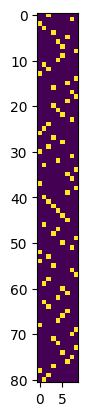

In [10]:
plt.imshow(train_data_logits[0])

In [11]:
show_sudoku(train_outputs[0])

+-------+-------+-------+
| 3 8 1 | 2 4 7 | 5 6 9 |
| 6 5 2 | 3 1 9 | 7 4 8 |
| 9 7 4 | 5 6 8 | 3 2 1 |
+-------+-------+-------+
| 4 6 3 | 1 8 5 | 2 9 7 |
| 8 1 9 | 7 2 3 | 4 5 6 |
| 7 2 5 | 4 9 6 | 8 1 3 |
+-------+-------+-------+
| 1 4 8 | 9 3 2 | 6 7 5 |
| 2 3 7 | 6 5 1 | 9 8 4 |
| 5 9 6 | 8 7 4 | 1 3 2 |
+-------+-------+-------+


In [12]:
class SudokuSampler(nn.Module, Sampleable):
    """
    Sampleable wrapper for the MNIST dataset
    """
    def __init__(self, train_data_logits, train_inputs, ):
        super().__init__()
        self.dataset = train_data_logits
        self.masks = (train_inputs == 0).reshape((*train_inputs.shape, 1))

        self.register_buffer("dummy", torch.zeros(81))

    def sample(self, num_samples: int) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        """
        Args:
            - num_samples: the desired number of samples
        Returns:
            - samples: shape (batch_size, c, h, w)
            - labels: shape (batch_size, label_dim)
        """
        if num_samples > len(self.dataset):
            raise ValueError(f"num_samples exceeds dataset size: {len(self.dataset)}")
        
        indices = torch.randperm(len(self.dataset))[:num_samples]
        
        samples = [torch.Tensor(self.dataset[i]) for i in indices]
        masks = [torch.Tensor(self.masks[i]) for i in indices]
        
        samples = torch.stack(samples).to(self.dummy)
        masks = torch.stack(masks).to(self.dummy)

        labels = samples*(1-masks)
        return samples, labels

    def sample_index(self, idx: int) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        """
        Args:
            - num_samples: the desired number of samples
        Returns:
            - samples: shape (batch_size, c, h, w)
            - labels: shape (batch_size, label_dim)
        """
        if idx > len(self.dataset):
            raise ValueError(f"idx exceeds dataset size: {len(self.dataset)}")

        indices = [idx,]
        
        samples = [torch.Tensor(self.dataset[i]) for i in indices]
        masks = [torch.Tensor(self.masks[i]) for i in indices]
        
        samples = torch.stack(samples).to(self.dummy)
        masks = torch.stack(masks).to(self.dummy)

        labels = samples*(1-masks)
        return samples, labels

In [13]:
num_rows = 3
num_cols = 3
num_timesteps = 5

# Dataset and probability path used for training
sampler = SudokuSampler(train_data_logits, train_inputs).to(device)
path = GaussianConditionalProbabilityPath(
    p_data = sampler,
    p_simple_shape = [81, 9],
    alpha = LinearAlpha(),
    beta = LinearBeta()
).to(device)

# Dataset and probability path used for testing
sampler_test = SudokuSampler(test_data_logits, test_inputs).to(device)
path_test = GaussianConditionalProbabilityPath(
    p_data = sampler_test,
    p_simple_shape = [81, 9],
    alpha = LinearAlpha(),
    beta = LinearBeta()
).to(device)

# Network architecture

In [14]:
class TimeFourier(nn.Module):
    def __init__(self, dim=64, max_freq=1000.0):
        super().__init__()
        half = dim // 2
        freqs = torch.exp(torch.linspace(0, math.log(max_freq), half))
        self.register_buffer("freqs", freqs)
        self.dim = dim

    def forward(self, t):
        # t: (B, 1)
        x = t * self.freqs[None, :] * 2 * math.pi  # (B, half)
        emb = torch.cat([torch.sin(x), torch.cos(x)], dim=-1)  # (B, 2*half)
        if emb.shape[-1] < self.dim:  
            emb = torch.cat([emb, torch.zeros_like(emb[:, :1])], dim=-1)
        return emb  # (B, dim)


class TransformerBlock(nn.Module):
    def __init__(self, hidden=128, heads=8, mlp_ratio=4.0, dropout=0.01):
        super().__init__()
        self.ln1 = nn.LayerNorm(hidden)
        self.attn = nn.MultiheadAttention(
            embed_dim=hidden, num_heads=heads, dropout=dropout, batch_first=True
        )
        self.ln2 = nn.LayerNorm(hidden)

        mlp_hidden = int(hidden * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(hidden, mlp_hidden),
            nn.GELU(),
            nn.Linear(mlp_hidden, hidden),
        )
        self.drop = nn.Dropout(dropout)

    def forward(self, x, attn_mask=None, key_padding_mask=None):
        # x: (B, 81, hidden)
        h = self.ln1(x)
        a, _ = self.attn(h, h, h, attn_mask=attn_mask, key_padding_mask=key_padding_mask)
        x = x + self.drop(a)             
        x = x + self.drop(self.mlp(self.ln2(x))) 
        return x


class SudokuAttentionVectorField(nn.Module):
    """
    A simple attention-based vector field / refinement model.

    Inputs:
      z: (B, 81, 9)  - per-cell 9-dim state (logits/probs/features)
      t: (B, 1)      - time / step

    Output:
      dz: (B, 81, 9) - update direction (same shape as z)
    """
    def __init__(self, hidden: int = 128, depth: int = 4, heads: int = 8, t_dim: int = 64, dropout: float = 0.01):
        super().__init__()
        self.time = TimeFourier(t_dim)
        self.t_proj = nn.Sequential(
            nn.Linear(t_dim, hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden),
        )

        # project per-cell state (9) into hidden token embedding
        self.in_proj = nn.Linear(9, hidden)

        # positional identity for Sudoku grid
        self.row_emb = nn.Embedding(9, hidden)
        self.col_emb = nn.Embedding(9, hidden)
        self.box_emb = nn.Embedding(9, hidden)

        # precompute (81,) indices as buffers
        rows = torch.arange(81) // 9
        cols = torch.arange(81) % 9
        boxs = (rows // 3) * 3 + (cols // 3)
        self.register_buffer("row_idx", rows, persistent=False)
        self.register_buffer("col_idx", cols, persistent=False)
        self.register_buffer("box_idx", boxs, persistent=False)

        self.blocks = nn.ModuleList([
            TransformerBlock(hidden=hidden, heads=heads, dropout=dropout)
            for _ in range(depth)
        ])

        self.out_ln = nn.LayerNorm(hidden)
        self.out_proj = nn.Linear(hidden, 9)

    def forward(self, z: torch.Tensor, t: torch.Tensor, attn_mask=None) -> torch.Tensor:
        # z: (B,81,9), t: (B,1)
        x = self.in_proj(z)  # (B,81,H)

        # add Sudoku coordinate embeddings
        pos = (self.row_emb(self.row_idx) +
               self.col_emb(self.col_idx) +
               self.box_emb(self.box_idx))  # (81,H)
        x = x + pos[None, :, :]  # (B,81,H)

        te = self.t_proj(self.time(t))  # (B,H)
        x = x + te[:, None, :]          # broadcast add time conditioning

        for blk in self.blocks:
            x = blk(x, attn_mask=attn_mask)

        x = self.out_ln(x)
        dz = self.out_proj(x)  # (B,81,9)
        return dz


In [15]:
class Trainer(ABC):
    def __init__(self, model: torch.nn.Module):
        super().__init__()
        self.model = model

    @abstractmethod
    def get_train_loss(self, **kwargs) -> torch.Tensor:
        pass

    def get_optimizer(self, lr: float):
        return torch.optim.Adam(self.model.parameters(), lr=lr)

    def prepare_training(self, device: torch.device, lr: float = 1e-3):
        self.model.to(device)
        self.opt = self.get_optimizer(lr)

    def train(self, num_epochs: int, device: torch.device, lr: float = 1e-3, **kwargs) -> torch.Tensor:
        # Start

        self.model.train()

        # Train loop
        pbar = tqdm(enumerate(range(num_epochs)))
        for idx, epoch in pbar:
            self.opt.zero_grad()
            loss = self.get_train_loss(**kwargs)
            loss.backward()
            self.opt.step()
            pbar.set_description(f'Epoch {idx}, loss: {loss.item()}')

            if epoch % 1000:
                torch.save(self.model.state_dict(), "model_128_square_time_tmp.pt")
                
        # Finish
        self.model.eval()

# Score matching

Here we train a separate network to estimate the score function.

In [16]:
class ConditionalScoreMatchingTrainer(Trainer):
    def __init__(self, path: ConditionalProbabilityPath, model: SudokuAttentionVectorField, **kwargs):
        super().__init__(model, **kwargs)
        self.path = path

    def get_train_loss(self, batch_size: int) -> torch.Tensor:
        z, _ = self.path.p_data.sample(batch_size)

        eps = 10**(-4)
        u = torch.rand(batch_size, 1, 1)
        t = (1 - eps)*(1 - (1-u)**2)

        z = z.to(device)
        t = t.to(device)
        
        x = self.path.sample_conditional_path(z,t)
        
        delta_p, beta_2 = self.path.conditional_score_no_beta(x,z,t)
        score_t = self.model(x,t.reshape(t.shape[0], -1))
        
        return torch.mean(torch.sum((score_t*beta_2 - delta_p)**2, -1))

In [17]:
score_model = SudokuAttentionVectorField()

In [18]:
state_dict = torch.load("score_model_tuned.pt", map_location="cpu")
score_model.load_state_dict(state_dict)
score_model = score_model.to(device)

In [19]:
trainer = ConditionalScoreMatchingTrainer(path, score_model)
trainer.prepare_training(device=device, lr=1e-5)

In [20]:
#losses = trainer.train(num_epochs=100_000, device=device, lr=1e-3, batch_size=2_000)

# SDE using a trained score model and $\beta(t)$ as diffusion coefficient

## Drift / velocity field from the score

A convenient way to define a dynamics compatible with the Gaussian path is via a (learned) velocity field of the form
$$
u(x,t) \;=\; u_{\text{flow}}(x,t) \;+\; \frac{1}{2}\sigma^2\, s_\theta(x,t),
$$
where $\sigma$ is a user-chosen scalar hyperparameter controlling the strength of the score-based correction term.

### The flow component $u_{\text{flow}}$

Let $\dot\alpha(t) = \frac{d}{dt}\alpha(t)$ and $\dot\beta(t) = \frac{d}{dt}\beta(t)$.
In our implementation we use the following expression:
$$
u_{\text{flow}}(x,t)
=
\frac{ \left(\beta(t)^2\,\dot\alpha(t) - \alpha(t)\beta(t)\dot\beta(t)\right)\, s_\theta(x,t) + \dot\alpha(t)\,x }{\alpha(t)}.
$$

In [21]:
class LangevinScoreSDE(SDE):
    def __init__(
        self,  
        score_model: SudokuAttentionVectorField, 
        path : ConditionalProbabilityPath,
        sigma: float
    ):
        """
        Args:
        - path: the ConditionalProbabilityPath object to which this vector field corresponds
        - z: the conditioning variable, (1, dim)
        """
        super().__init__()
        self.score_model = score_model
        self.sigma = sigma
        self.path = path

    def drift_coefficient(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - x: state at time t, shape (bs, dim)
            - t: time, shape (bs,.)
        Returns:
            - u_t(x|z): shape (batch_size, dim)
        """
        t = t.reshape(t.shape[0], -1)
        sigma_shape = (self.path.beta(t).shape[0], 1, 1)

        beta = self.path.beta(t).reshape(sigma_shape)
        alpha = self.path.alpha(t).reshape(sigma_shape)

        beta_dt = self.path.beta.dt(t).reshape(sigma_shape)
        alpha_dt = self.path.alpha.dt(t).reshape(sigma_shape)

        score = self.score_model(x, t)
        u_flow = ((beta**2)*alpha_dt - alpha*beta_dt*beta)*score + alpha_dt*x
        if t[0] > 0:
            u_flow = u_flow/alpha
        else:
            u_flow = u_flow/1e-2
        return u_flow + 0.5 * self.sigma ** 2 * score#/(self.path.beta(t).reshape(-1, 1, 1)**2)

    def diffusion_coefficient(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - x: state at time t, shape (bs, dim)
            - t: time, shape (bs,.)
        Returns:
            - u_t(x|z): shape (batch_size, dim)
        """
        sigma_shape = (self.path.beta(t).shape[0], 1, 1)
        beta = self.path.beta(t).reshape(sigma_shape)
        return beta#self.sigma * torch.randn_like(x)

# Solving a custom Sudoku

Below we solve a user-defined Sudoku instance (encoded as an 81-length vector with zeros for blanks).  
Note that Sudoku difficulty varies significantly across instances: puzzles with very few givens (e.g., 17–20 clues) are typically challenging because the conditioning signal is weak and the solver must resolve many global constraints.

## Runtime notes (stochastic solver + early stopping)

Our sampler is **stochastic**: each trajectory may or may not land on a valid Sudoku solution.  
Therefore, we generate solutions in **parallel batches** and apply **early stopping**:

- In each run we sample a batch of `num_samples` candidate solutions (trajectories).
- We validate all candidates and **stop immediately** once at least one valid solution is found.
- This makes the method an **anytime algorithm**: more compute increases the probability of success.

In practice, hard instances can require multiple batches. However, batch sampling is **parallel** and scales well with available GPU resources.

### Example (this puzzle)
For the custom puzzle below, the solver found a valid solution in approximately **2 minutes** using:
- batch size `num_samples = 2000`
- **7 runs** (i.e., about `7 × 2000 = 14,000` trajectories evaluated in total)

Because we stop at the first success, this number can vary across runs.

In [22]:
custom_sudoku = [1, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0,
       2, 0, 6, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0,
       5, 5, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 3, 0, 0, 7, 0, 0, 6,
       0, 0, 0, 0, 0, 0, 0, 9, 4, 0, 0, 0, 0, 0, 0]
custom_sudoku = np.array(custom_sudoku)
mask = (custom_sudoku == 0).reshape(-1,1)
custom_sudoku_one_hot = np.eye(9)[custom_sudoku - 1]
z_custom_given = custom_sudoku_one_hot*(1-mask)
z_custom_given = z_custom_given.reshape(1, 81, 9)
z_custom_given = torch.tensor(z_custom_given).float().to(device)

Runs taken: 7.
Time spent: 2 min 18.4 s
Valid sudokus:1/512


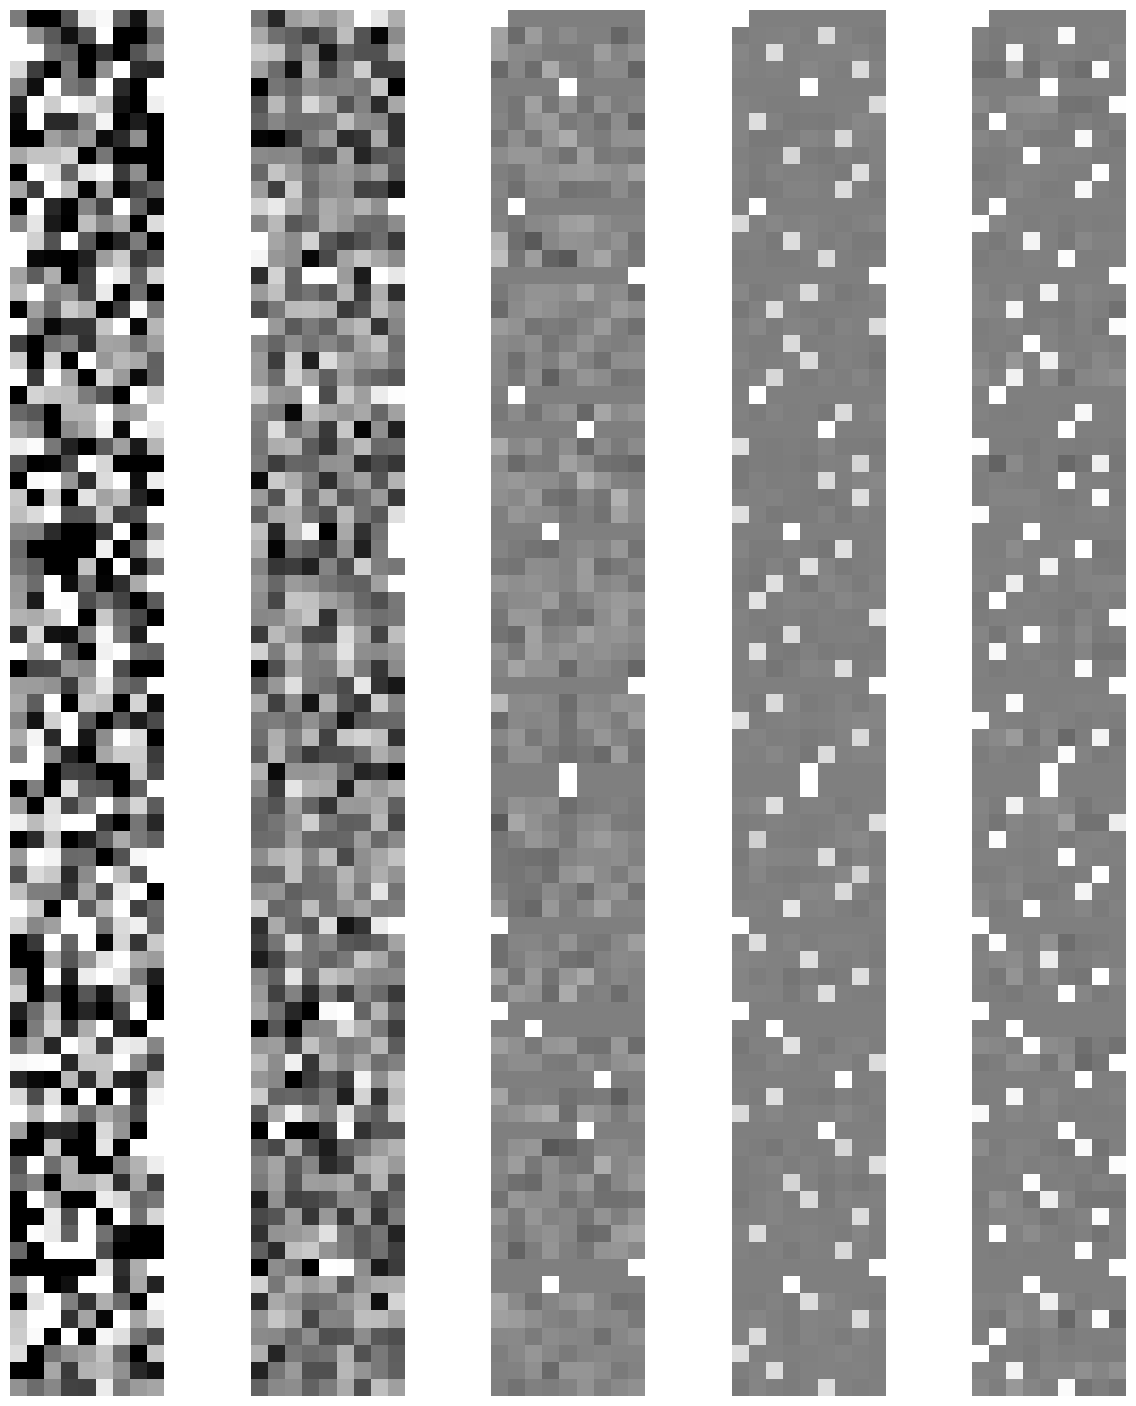

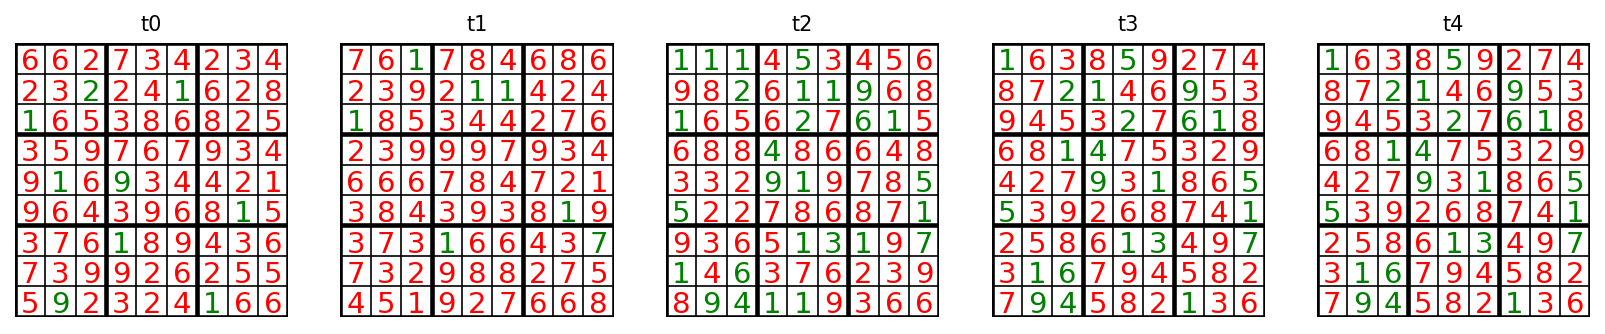

In [23]:
index_to_solve = 211
num_samples= 512
num_timesteps = 300
num_marginals = 4
sigma = 2.3 #recommended to keep this sigma

torch.cuda.manual_seed(1)
import time
start = time.time()

#z, z_given = path_test.sample_conditioning_variable_by_index(index_to_solve) # (1,2)
z = z_custom_given
z_given = z_custom_given
mask = torch.sum(z_given, -1, keepdims=True)

for j in range(1000):
    threshold_hard = np.random.choice([0.0, 0.4, 0.45, 0.5, 0.8])
    sde = LangevinScoreSDE(score_model, path, sigma)
    simulator = GuidedPathEulerMaruyamaSimulator(sde, threshold_hard=threshold_hard)
    #sampling noise
    x0, _ = path_test.p_simple.sample(num_samples) 
    ts = torch.linspace(0.0, 1.0, num_timesteps).view(1,-1,1,1).expand(num_samples,-1,1,1).to(device) # (num_samples, nts, 1)
    
    #running simulator with the score model
    # here we visualize the trajectory, so we keep track of it
    # use simulator.simulate if you want just a solution!
    
    xts = simulator.simulate_with_trajectory(x0, ts, z_guided=z_given, mask=mask, path=path, use_tqdm=False) # (bs, nts, dim)
    solutions = xts[:, -1].argmax(dim=-1).cpu().numpy()
    
    #xts = simulator.simulat(x0, ts, z_guided=z_given, mask=mask, path=path, use_tqdm=False) # (bs, nts, dim)
    #solutions = xts[:, -1].argmax(dim=-1).cpu().numpy()

   
    report = [sudoku81_report(sol+1) for sol in solutions]
    report = np.array(report)
    
    i = 0
    if np.max(np.mean(report, -1)) == 9:
        i = np.argmax(np.mean(report, -1))
    
    indexes = np.where(np.mean(report, -1) == 9)
    if np.sum(np.where(np.mean(report, -1) == 9)) > 0:
        break
print(f"Runs taken: {j}.")
elapsed = time.time() - start
mins, secs = divmod(elapsed, 60)
print(f"Time spent: {int(mins)} min {secs:.1f} s")
print(f"Valid sudokus:{np.sum([valid_sudoku81(sol+1) for sol in solutions])}/{len(solutions)}")
    
cells_history = []
every_n = record_every(num_timesteps=num_timesteps, record_every=num_timesteps // num_marginals)

xts_every_n = xts[:,every_n,:] # (bs, nts // n, dim)
ts_every_n = ts[0,every_n] # (nts // n,)

fig, axes = plt.subplots(1, xts_every_n.shape[1], figsize=(num_cols * xts_every_n.shape[1], 6 * num_rows))
for plot_idx in range(xts_every_n.shape[1]):
    tt = ts_every_n[plot_idx].view(1,1,1,1).expand(num_samples, 1, 1, 1) # (num_samples, 1, 1, 1)
    xt = xts_every_n[i, plot_idx]
    grid = make_grid(xt, nrow=num_cols, normalize=True, value_range=(-1,1))
    axes[plot_idx].imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
    axes[plot_idx].axis("off")

    cells_history.append(xt.argmax(axis=-1).to("cpu").numpy()+1)
plt.show()

gt = z[0].argmax(dim=-1).cpu().numpy()+1     # (81,)
draw_sudoku_path(cells_history, gt=gt, titles=[f"t{i}" for i in range(len(cells_history))])



In [24]:

if len(indexes)>0:
    #visualize successful run if present
    x = xts[indexes[0][0]]
else:
    x = xts[0]

#x = x[:88]    
p = reshape_sudoku_probs(x)  # x is [T,81,9]
#render_entropy_gif(p, "solving_sudoku_with_given_constraints.gif", fps=20, show_digits=True)
render_guided_entropy_gif(p, z_given[0], "solving_sudoku_with_given_constraints.gif", fps=20, show_digits=True)



'solving_sudoku_with_given_constraints.gif'